<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-SG-42 Project 3: Web APIs & NLP
### Reddit Scams: Are We Vulnerable?
---

## 3. Exploratory Data Analysis

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import math
from scipy import stats

# Set display settings
pd.set_option('display.width', 10000)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# import dataset
clean_df = pd.read_csv('../data/cleaned_data.csv', lineterminator='\n')

# Reorder the columns and drop URL
clean_df = clean_df[['id', 'type', 'subreddit', 'cleaned_text']]

# Remove the index column
clean_df.reset_index(drop=True, inplace=True)
print(clean_df.head())

        id     type       subreddit                                       cleaned_text
0  1bkqx22    title  RandomKindness  today is my birthday i just want someone to be...
1  1bkqx22     body  RandomKindness  i dont normally do things like this today i tu...
2  1bkqx22  comment  RandomKindness  youre doing amazing and im proud of you someti...
3  1bkqx22    reply  RandomKindness                       this made me smile thank you
4  1bkqx22    reply  RandomKindness                                        i love this


### Defining a Post & an Entry
- A post consist of a title, body, comment, reply
- We refer to each row in our dataframe as an entry

### 3.1 Word and Character Count 

#### 3.1.1 Creating Word and Character Count

In order to create a distribution of words in each of the text type (title, title body, comment, reply), we will create a word and character count so we can conduct an exploratory data analysis. 

In [3]:
# create empty lists to append
word_count = []
char_count = []

# create word/character counter that can be appended
total_word_count = 0
total_char_count = 0

# for-loop each row in the column
for entry in clean_df['cleaned_text']:
    
    # remove whitespace from each entry
    entry = entry.strip()

    # try-except block to catch float that will throw an AttributeError 
    try:
        split_terms = entry.split(' ') # split each row into individual words

        # append word count to word_count list 
        word_count.append(len(split_terms))

        # initialize character count for the current entry
        entry_char_count = 0

        # split each word into their characters
        for word in split_terms: 
            split_word = list(word) # split each word into their characters
            entry_char_count += len(word) # increase counter
            if word != '': # if it is not empty add counter by 1
                total_word_count+=1

        # append the character count of the current entry to char_count list
        char_count.append(entry_char_count)

    except AttributeError: # continue loop if encounter a float
            continue
    

# Assign columns with word and character count    
clean_df['word_count'] = word_count
clean_df['char_count'] = char_count

# inspect first 10 rows of the dataframe
print(clean_df.head(10))

        id     type       subreddit                                       cleaned_text  word_count  char_count
0  1bkqx22    title  RandomKindness  today is my birthday i just want someone to be...          11          44
1  1bkqx22     body  RandomKindness  i dont normally do things like this today i tu...          87         359
2  1bkqx22  comment  RandomKindness  youre doing amazing and im proud of you someti...          36         547
3  1bkqx22    reply  RandomKindness                       this made me smile thank you           6          23
4  1bkqx22    reply  RandomKindness                                        i love this           3           9
5  1bkqx22    reply  RandomKindness  where did you find the virtual bubble wrap tha...          27          97
6  1bkqx22    reply  RandomKindness                                             poppop           1           6
7  1bkqx22    reply  RandomKindness  yay im happy its your birthday cause now we ca...          17          64
8

- A custom function will be created to extract the statistics like total number and mean of the dataframe. 
- To prevent exessive loops, a custom function will be used to calculations for the values needed. 
- This function will be able to extract the information needed and exported into a dataframe. 
- The below function will only obtain statistics from one subreddit.

In [4]:
# Custom function to calculate the key statistics for one subreddit
def get_subreddit_stat(some_dataframe: pd.DataFrame, subreddit_choice: str) -> pd.DataFrame:

    a_subreddit = some_dataframe[some_dataframe['subreddit'] == subreddit_choice] # filter df to one subreddit 

    num_unique_post = len(set(a_subreddit['id'])) # obtain the total number of posts

    # as comments and replies are under the comments section, they will be considered as one
    num_comments = len(a_subreddit[a_subreddit['type']=='reply']) + len(a_subreddit[a_subreddit['type']=='comment']) # total number of comments

    # total word count in the subreddit
    total_word_count = a_subreddit['word_count'].sum()

    # total character count in the subreddit
    # total word count in the subreddit
    total_char_count = a_subreddit['char_count'].sum()
 
    # compile the statistics into a dictionary
    subreddit_dict = {
        'No Unique Posts': num_unique_post,
        'Total Comments': num_comments,
        'Total Word Count': total_word_count,
        'Total Character Count': total_char_count,
    }

    # convert the dictionary into a dataframe
    subreddit_df = pd.DataFrame(subreddit_dict, index = [subreddit_choice])
    
    return subreddit_df

Similar to the custom function get_subreddit_stat(), the modified function below extracts information from both subreddits, instead of creating one for-loop.

In [5]:
# to modify the function to get the statistics for both subreddit

def get_total_subreddit_stat(some_dataframe: pd.DataFrame) -> pd.DataFrame:

    num_unique_post = len(set(some_dataframe['id'])) # obtain the total number of posts

    # as comments and replies are under the comments section, they will be considered as one
    num_comments = len(some_dataframe[some_dataframe['type']=='reply']) + len(some_dataframe[some_dataframe['type']=='comment']) # total number of comments

    # total word count in the subreddit
    total_word_count = some_dataframe['word_count'].sum()

    # total character count in the subreddit
    # total word count in the subreddit
    total_char_count = some_dataframe['char_count'].sum()

    # compile the statistics into a dictionary
    subreddit_dict = {
        'No Unique Posts': num_unique_post,
        'Total Comments': num_comments,
        'Total Word Count': total_word_count,
        'Total Character Count': total_char_count,
    }

    # convert the dictionary into a dataframe
    subreddit_df = pd.DataFrame(subreddit_dict, index = ['Total'])
    
    return subreddit_df

#### 3.1.2 Descriptive Statistics on Word and Character Count

In [6]:
# filter the subreddits into their individual dataframes

rk = clean_df[clean_df['subreddit'] == 'RandomKindness']
sc = clean_df[clean_df['subreddit'] == 'Scams']

In [7]:
# Using the custom function above to obtain the key statistics of the word, character count

both_subreddit = get_total_subreddit_stat(clean_df) # modified function to get stats our from combined df
sc_df = get_subreddit_stat(clean_df, 'Scams') # use custom function to get stats from r/Scams
rk_df = get_subreddit_stat(clean_df, 'RandomKindness') # use custom function to get stats from r/RandomKindness

# merge into one df
combined_df = sc_df.merge(rk_df, how = 'outer')
combined_df = combined_df.merge(both_subreddit, how='outer')
index_list = ['r/Scams', 'r/RandomKindness', 'Both Subreddits']  # insert identifiers
combined_df.index = index_list
combined_df # inspect df

,No Unique Posts,Total Comments,Total Word Count,Total Character Count
r/Scams,971,11673,570053,2410737
r/RandomKindness,900,12020,424465,1747677
Both Subreddits,1871,23693,994518,4158414


In [8]:
# Check for class imbalance between r/Scams and r/RandomKindness
scams_samples = combined_df.loc['r/Scams', 'No Unique Posts']
rk_samples = combined_df.loc['r/RandomKindness', 'No Unique Posts']
both_samples = combined_df.loc['Both Subreddits', 'No Unique Posts']

check_imbalance = (rk_samples - scams_samples) / both_samples * 100

print(f'The percentage difference between subreddits: {check_imbalance:.2f}%')
print(f'Total number of data entries: {len(clean_df)}')


The percentage difference between subreddits: -3.79%
Total number of data entries: 27335


- From the summary table above, we can see that there are a total number of 1871 unique posts with a marginal imbalance of 3.79%. 
- Considering that we have 27335 entries, our class imbalance will not be deemed problematic in the analysis. 
- The subreddit r/Scams has a higher mean comments per post but a lower total word count and mean words per post as compared to r/RandomKindness.

##### Descriptive Statistics for Word Count

In [9]:
# Generate statistics for both subreddits and overall for Word count
sc_stats = clean_df[clean_df['subreddit'] == 'Scams']['word_count'].describe()
rk_stats = clean_df[clean_df['subreddit'] == 'RandomKindness']['word_count'].describe()
both_stats = clean_df['word_count'].describe()

# Combine these statistics into a single DataFrame for a horizontal view
combined_stats = pd.DataFrame({'r/RandomKindness': rk_stats, 'r/Scams': sc_stats, 'Both Subreddits': both_stats})

# Transpose the DataFrame for a horizontal table
combined_stats_t = combined_stats.T

# Optionally, rename the index for clarity
combined_stats_t.index.name = 'Subreddit'

# Display the DataFrame
combined_stats_t.transpose()

Subreddit,r/RandomKindness,r/Scams,Both Subreddits
count,13756.000000,13579.000000,27335.000000
mean,30.856717,41.980485,36.382586
std,52.910134,62.504255,58.140852
min,1.000000,1.000000,1.000000
25%,7.000000,10.000000,8.000000
50%,16.000000,23.000000,19.000000
75%,33.000000,50.000000,41.000000
max,1570.000000,1306.000000,1570.000000


- The descriptive table above shows the different statistics for `word_count`. 
- The standard deviation for individual subreddits and combined subreddits are higher than the mean, indicating that the data points are more spread out from the mean value. 
- This would suggest that there is considerable amount of variability in the word counts in each text type. 
- Outliers will be investigated as the maximum word count is much higher than the mean. 

##### Descriptive Statistics for Character Count

In [10]:
# Generate statistics for both subreddits and overall using Character count
sc_stats = clean_df[clean_df['subreddit'] == 'Scams']['char_count'].describe()
rk_stats = clean_df[clean_df['subreddit'] == 'RandomKindness']['char_count'].describe()
both_stats = clean_df['char_count'].describe()

# Combine these statistics into a single DataFrame for a horizontal view
combined_stats = pd.DataFrame({'r/RandomKindness': rk_stats, 'r/Scams': sc_stats, 'Both Subreddits': both_stats})

# Transpose the DataFrame for a horizontal table
combined_stats_t = combined_stats.T

# Optionally, rename the index for clarity
combined_stats_t.index.name = 'Subreddit'

# Display the DataFrame
combined_stats_t.transpose()

Subreddit,r/RandomKindness,r/Scams,Both Subreddits
count,13756.000000,13579.000000,27335.000000
mean,127.048343,177.534207,152.127821
std,221.185710,264.630668,245.036619
min,1.000000,1.000000,1.000000
25%,29.000000,44.000000,35.000000
50%,62.000000,98.000000,77.000000
75%,133.000000,208.000000,171.000000
max,6109.000000,5032.000000,6109.000000


- The descriptive table above shows the different statistics for `char_count`. 
- The trend for character count is very similar to `word_count`. 
- The standard deviation for individual subreddits and combined subreddits are higher than the mean, indicating that the data points are more spread out from the mean value. 
- This would suggest that there is considerable amount of variability in the character counts in each text type. 
- Outliers will be investigated as the maximum word count is much higher than the mean. 
- This highly suggests that `word_count` and `char_count` are highly correlated. 
- After the investigation, as these two are highly correlated, we will focus on one count instead.

### 3.2 Visualisations

#### 3.2.1 Frequented Words

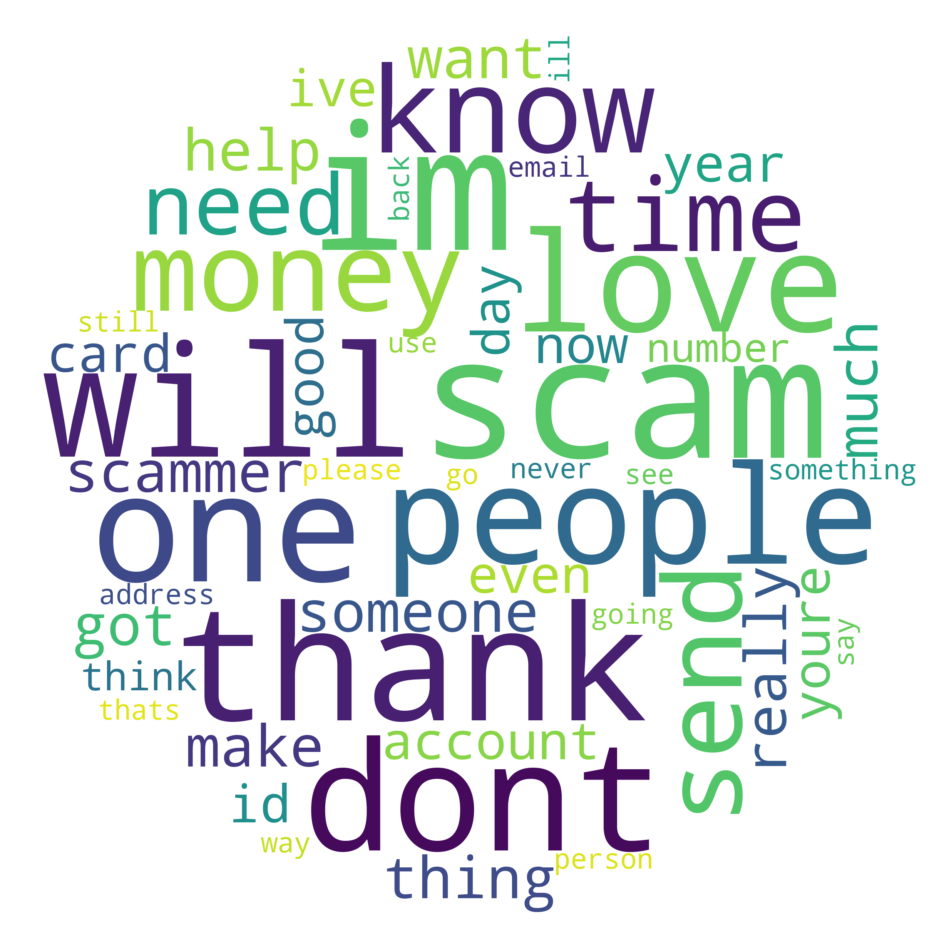

In [11]:
# Word Cloud for frequent words used overall

# Aggregate all entries in 'cleaned_text' into a single string
text = ' '.join(clean_df['cleaned_text'].dropna())

# Creating a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate a word cloud image with custom layout
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    max_words=50, 
    max_font_size=150, 
    scale=3,
    random_state=42,
    collocations=False,  # Calculate frequencies from text directly, might be slower
    colormap='viridis',
    mask=mask  # Choosing a colormap: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
).generate(text)

# Display the generated image:
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

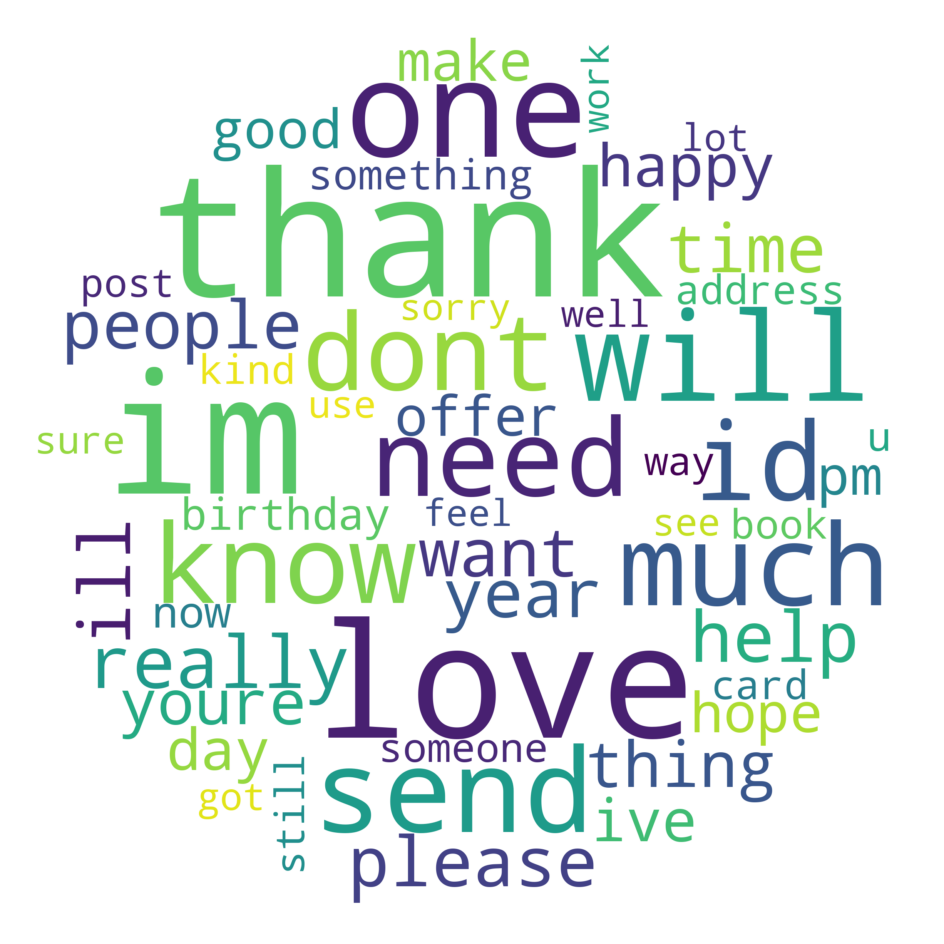

In [12]:
# Word Cloud for frequent words used r/RandomKindness

# Creating a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

random_kindness_texts = clean_df[clean_df['subreddit'] == 'RandomKindness']['cleaned_text']

# Combine all texts into a single string
combined_text = " ".join(text for text in random_kindness_texts)

# Generate a word cloud image with custom layout
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    max_words=50, 
    max_font_size=150, 
    scale=3,
    random_state=42,
    collocations=False,  # Calculate frequencies from text directly, might be slower
    colormap='viridis',
    mask=mask  # Choosing a colormap: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
).generate(combined_text)

# Display the generated image:
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

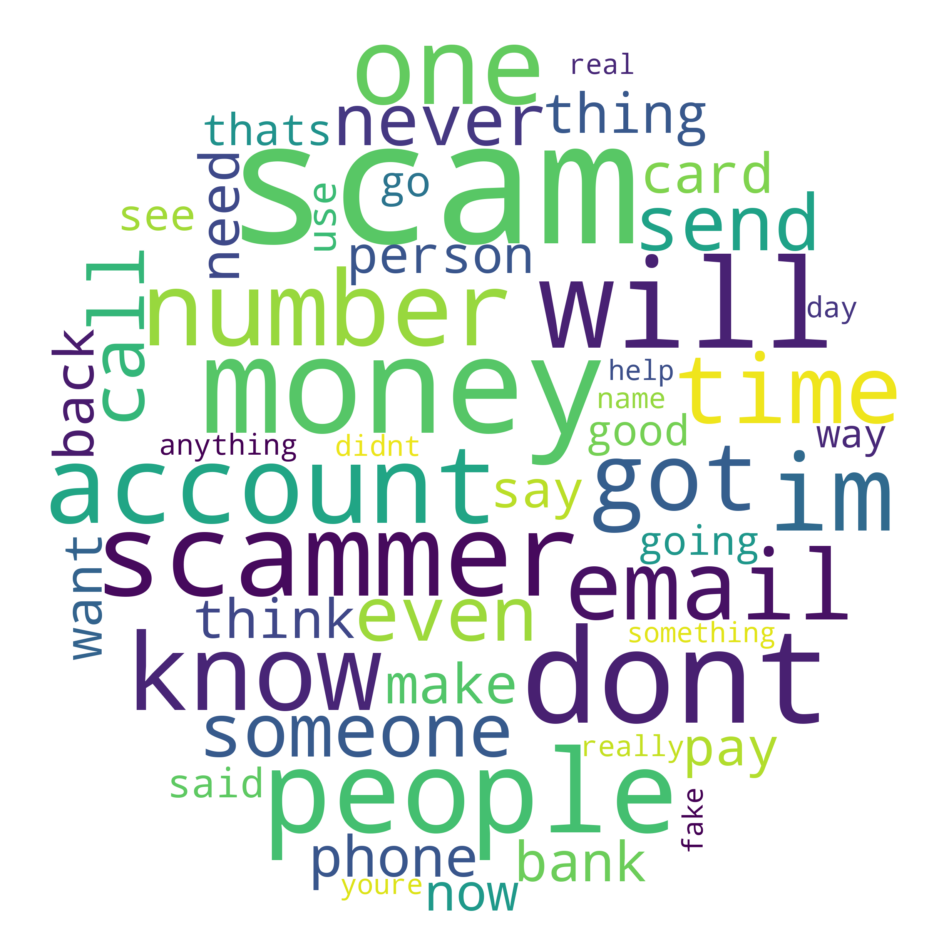

In [13]:
# Word Cloud for frequent words used r/Scams

# Filter the DataFrame for the r/Scams subreddit and aggregate text
scams_df = clean_df[clean_df['subreddit'] == 'Scams']
scams_texts = ' '.join(scams_df['cleaned_text'].dropna())

# Creating a circular mask
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 390 ** 2
mask = 255 * mask.astype(int)

# Generate a word cloud image with custom layout
wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color='white', 
    max_words=50, 
    max_font_size=150, 
    scale=3,
    random_state=42,
    collocations=False,  # Calculate frequencies from text directly, might be slower
    colormap='viridis',
      mask=mask  # Choosing a colormap: 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
).generate(scams_texts)

# Display the generated image:
plt.figure(figsize=(20, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Analysis:**

1. Overall
    * From both subreddits, words like 'Scam', 'thank', 'dont', 'will', 'one' shouts loud.
    * That said, the words can come from either subreddits and are not definitive that they are in both subreddits - i.e. word like 'thank' is more frequented in r/RandomKindness vs. r/Scams
2. Common words (in brief)
    * At first glance, some Common words between both the subreddits are 'people', 'someone', 'help'
    * We will further look into N-Grams (refer to Notebook 04) to ascertain the common words after tokenizing and removing stopwords

#### 3.2.2 Count of Post 

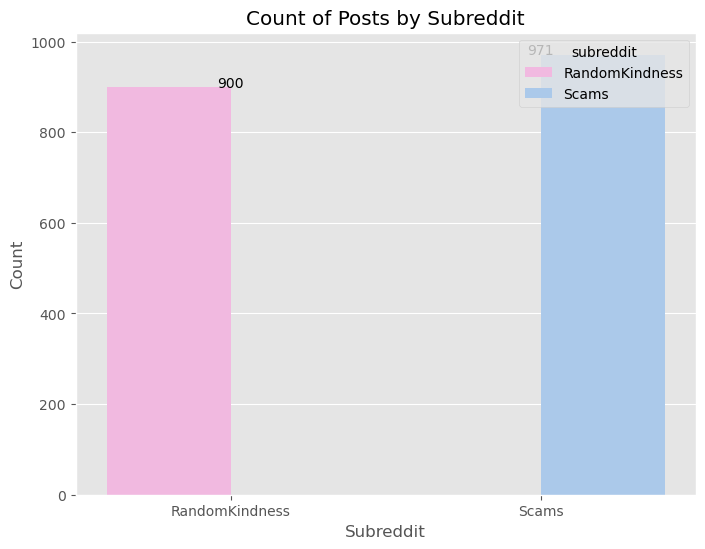

In [14]:
# Set theme of visualizations to ggplot
plt.style.use('ggplot')

# Import custom color palette
colors = sns.color_palette("pastel", 10)

# Create custom palette for each subreddit
custom_palette = {'RandomKindness': colors[6],
                  'Scams': colors[0]}

# Count the number of posts in each subreddit
subreddit_counts = clean_df.groupby('subreddit')['id'].nunique()

# Filter for only 'RandomKindness' and 'Scams'
subreddit_counts_filtered = subreddit_counts[subreddit_counts.index.isin(['RandomKindness', 'Scams'])].reset_index()

# Plot vertical bar graph
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='subreddit', y='id', data=subreddit_counts_filtered, hue = 'subreddit', palette=custom_palette)

# Add value labels above bars
for index, row in subreddit_counts_filtered.iterrows():
    bars.text(index, row.id, row.id, color='black', ha="center")

plt.xlabel('Subreddit')
plt.ylabel('Count')
plt.title('Count of Posts by Subreddit')
plt.xticks(rotation=0)
plt.show()


**Analysis**

- In total, 1871 posts were scraped between the r/RandomKindness(900) and r/Scams(971). 
- As mentioned above, the difference of the number of post is 3.79% and will be assumed as satisfactory.


#### 3.2.3 Distribution of Mean Word Counts by Type

#### 3.2.3.1 Distribution of Mean Word Counts by Type, in both Subreddits

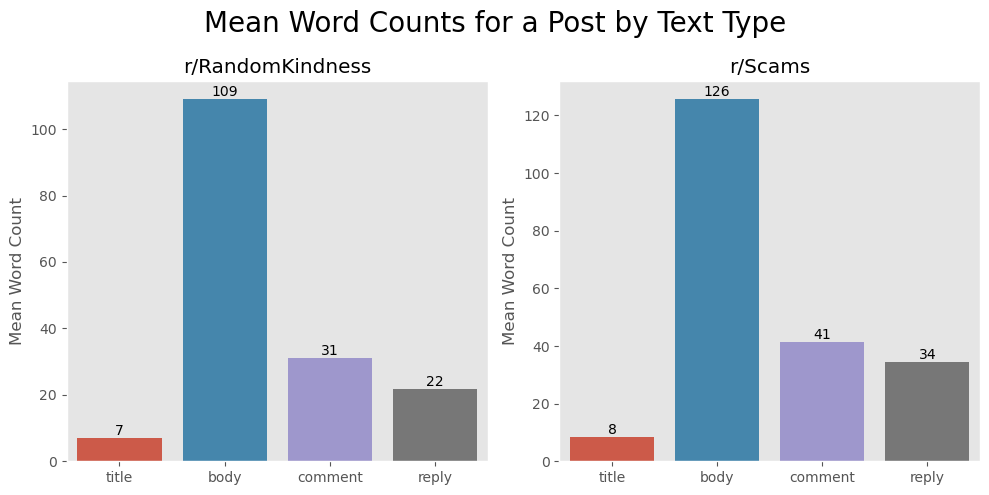

In [15]:
# Barplots of Word Counts of both subreddits
fig, axes = plt.subplots(1,2,figsize=(10, 5))

# plot of r/RandomKindness
rk_word_plot = sns.barplot(x='type',y = 'word_count', data=rk, errorbar=None, ax = axes[0])
axes[0].set_title('r/RandomKindness')
axes[0].set_xlabel('')
axes[0].set_ylabel('Mean Word Count')
axes[0].grid(axis='y')

# Add value labels above bars for r/RandomKindness
for bar in rk_word_plot.patches:
    axes[0].annotate(format(bar.get_height(), '.0f'), 
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom')

# plot of r/Scams
sc_word_plot = sns.barplot(x='type',y = 'word_count', data=sc, errorbar=None,ax = axes[1])
axes[1].set_title('r/Scams')
axes[1].set_xlabel('')
axes[1].set_ylabel('Mean Word Count')
axes[1].grid(axis='y')

# Add value labels above bars for r/Scams
for bar in sc_word_plot.patches:
    axes[1].annotate(format(bar.get_height(), '.0f'), 
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom')

# include a title 
plt.suptitle('Mean Word Counts for a Post by Text Type', size=20)

plt.tight_layout()
plt.show()

**ANALYSIS**
- In r/RandomKindness Titles have a lowest mean word count of 7 while the highest mean word count occurs in the Body with a mean word count of 109. Comments and Reply has a mean word count of 31 and 22 respectively.
- In r/Scams Titles have a lowest mean word count of 8 while the highest mean word count occurs in the Body with a mean word count of 126. Comments and Reply has a mean word count of 41 and 35 respectively.
- r/Scams have a higher mean word count across all types as compared to r/RandomKindness


**Overall Analysis**
- Titles have the lowest word count which can be expected due to the word limit imposed by Reddit.
- The Body of the post has the highest mean word count which is typical as that is where the main content of the post lies.
- The mean word count between Comments and Reply are low but the variation between them indicates that the interactive nature between comments or posts need not require many words. 
- Across the types of text types, r/Scams have a higher mean count, which suggests that r/Scams are more detailed and the community are more involved. 

#### 3.2.3.2 Distribution of Mean Word Counts by Type by Subreddit

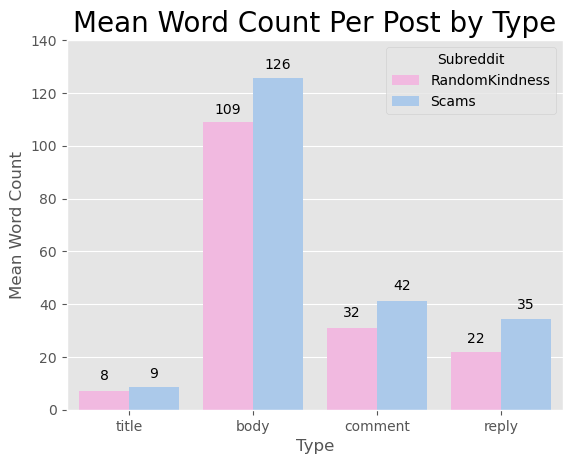

In [16]:
# Create a plot for presentation based on the mean word count of the individual subreddits

# Concatenate the two dataframes into one for plotting
combined_df = pd.concat([rk, sc], axis=0)

# import custom color palette
colors = sns.color_palette("pastel", 10) 
# sns.palplot(colors) # view color options

# create custom palette for each subreddit
custom_palette = {'RandomKindness': colors[6],
                  'Scams': colors[0]}


# Create a stacked bar plot
barplot = sns.barplot(data=combined_df, x='type', y='word_count', hue='subreddit', errorbar = None, palette=custom_palette)

# Annotate each bar with the value
for p in barplot.patches:
    height = math.ceil(p.get_height())
    if height > 0:  # You can set a different threshold if needed
        barplot.annotate('{}'.format(height), 
                         (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='bottom',
                         xytext=(0, 4), textcoords='offset points')

plt.xlabel('Type')
plt.ylabel('Mean Word Count')
plt.ylim(0,140)
plt.title('Mean Word Count Per Post by Type', size=20)
plt.legend(title='Subreddit')

plt.show()

#### 3.2.4 Distribution of Comments and Replies 

In [17]:
# Filter for r/RandomKindness and r/Scams
rk_df = clean_df[clean_df['subreddit'] == 'RandomKindness']
scams_df = clean_df[clean_df['subreddit'] == 'Scams']

# Calculate comments per post for each subreddit
comments_per_post_rk = rk_df[rk_df['type'] == 'comment'].groupby('id').size()
comments_per_post_scams = scams_df[scams_df['type'] == 'comment'].groupby('id').size()

# Calculate replies per post for each subreddit
replies_per_post_rk = rk_df[rk_df['type'] == 'reply'].groupby('id').size()
replies_per_post_scams = scams_df[scams_df['type'] == 'reply'].groupby('id').size()

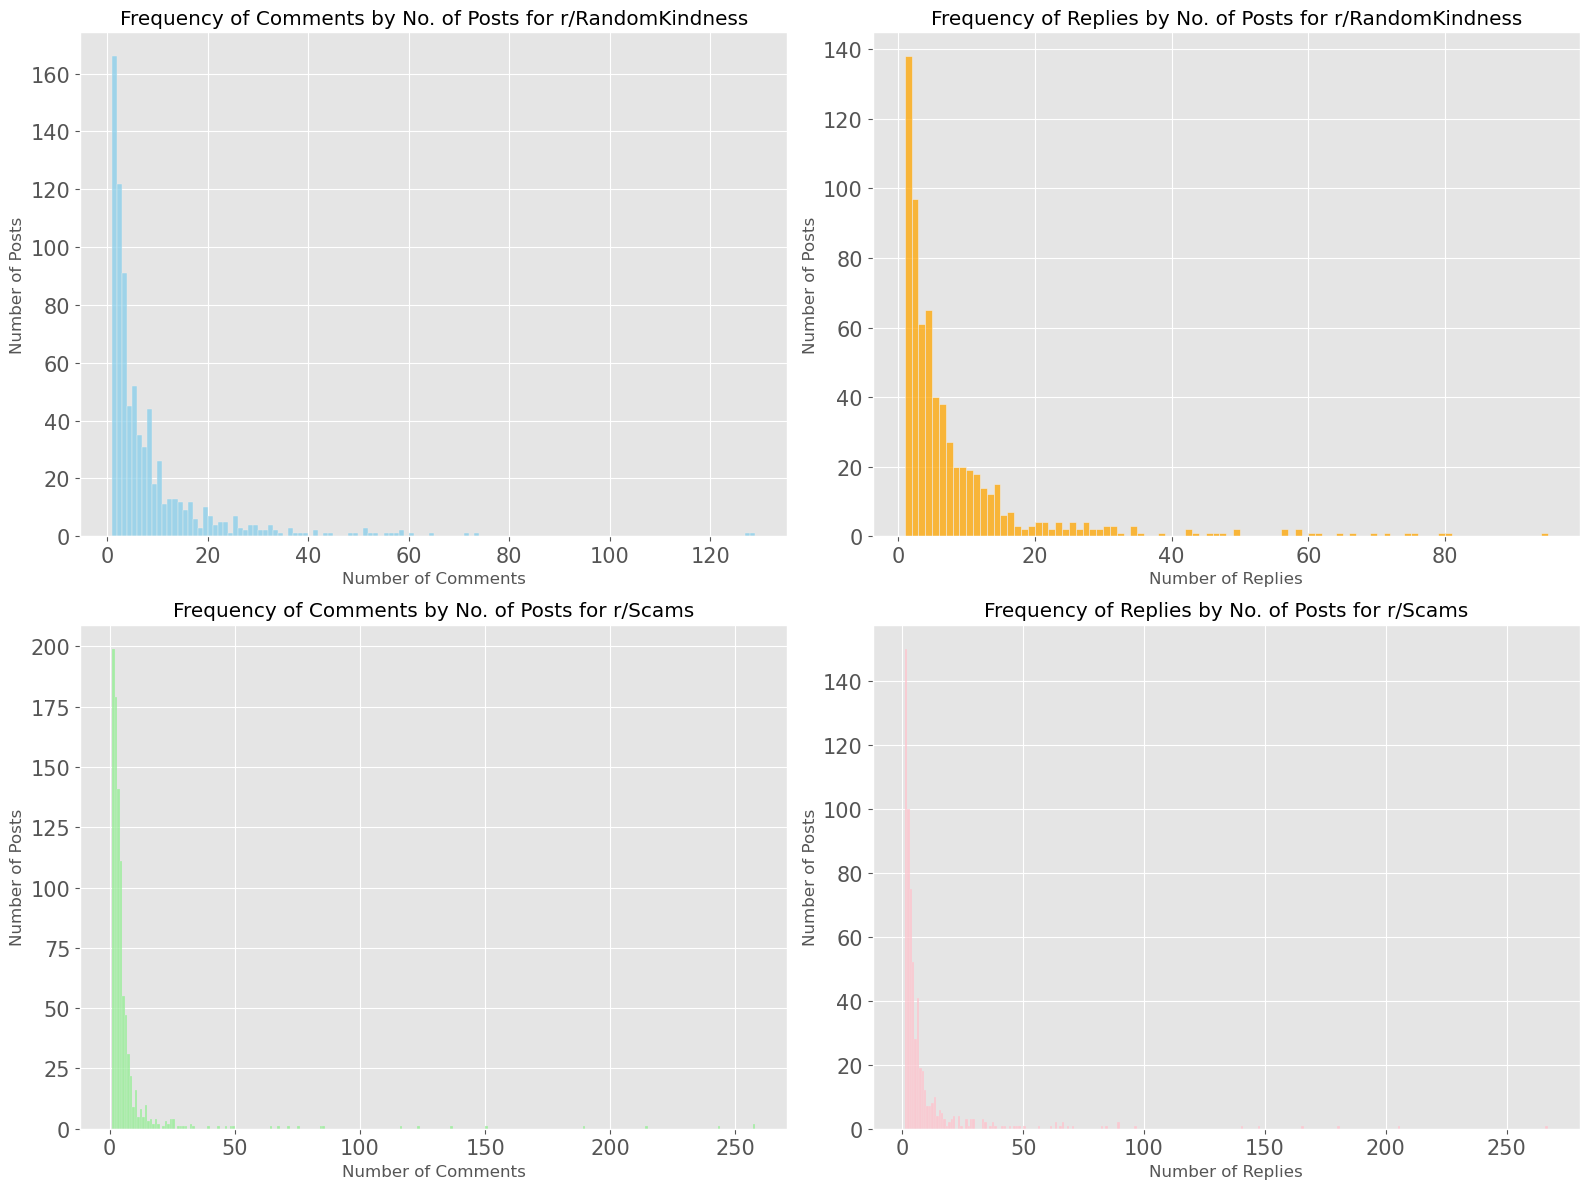

In [18]:
# Setting up the plotting area
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plotting the distribution of comments per post for r/RandomKindness
sns.histplot(comments_per_post_rk, ax=axs[0, 0], color='skyblue', binwidth=1)
axs[0, 0].set_title('Frequency of Comments by No. of Posts for r/RandomKindness')
axs[0, 0].set_xlabel('Number of Comments')
axs[0, 0].tick_params(axis='x', labelsize=15)
axs[0, 0].tick_params(axis='y', labelsize=15)  
axs[0, 0].set_ylabel('Number of Posts')

# Plotting the distribution of replies per post for r/RandomKindness
sns.histplot(replies_per_post_rk, ax=axs[0, 1], color='orange', binwidth=1)
axs[0, 1].set_title('Frequency of Replies by No. of Posts for r/RandomKindness')
axs[0, 1].set_xlabel('Number of Replies')
axs[0, 1].tick_params(axis='x', labelsize=15)
axs[0, 1].tick_params(axis='y', labelsize=15)  
axs[0, 1].set_ylabel('Number of Posts')

# Plotting the distribution of comments per post for r/Scams
sns.histplot(comments_per_post_scams, ax=axs[1, 0], color='lightgreen', binwidth=1)
axs[1, 0].set_title('Frequency of Comments by No. of Posts for r/Scams')
axs[1, 0].set_xlabel('Number of Comments')
axs[1, 0].tick_params(axis='x', labelsize=15)
axs[1, 0].tick_params(axis='y', labelsize=15)  
axs[1, 0].set_ylabel('Number of Posts')

# Plotting the distribution of replies per post for r/Scams
sns.histplot(replies_per_post_scams, ax=axs[1, 1], color='pink', binwidth=1)
axs[1, 1].set_title('Frequency of Replies by No. of Posts for r/Scams')
axs[1, 1].set_xlabel('Number of Replies')
axs[1, 1].tick_params(axis='x', labelsize=15)
axs[1, 1].tick_params(axis='y', labelsize=15)  
axs[1, 1].set_ylabel('Number of Posts')

plt.tight_layout()
plt.show()

**Analysis:**

Looking at the comments and replies per post for both subreddits - r/RandomKindness and r/Scams, we note that:

1. Right-skewed distribution
    * In general it's a positive/right-skewed distribution, with decreased frequency as the comments or replies increases - i.e. there are fewer comments and replies in most of the posts
2. No. of Comments
    * The frequency of comments is higher in r/Scams (comments up to 200 posts) than in r/RandomKindness (comments up to 160 posts)
3. No. of Replies
    * The frequency of replies is higher in r/Scams (replies of > 140 posts) than in r/RandomKindness (replies of up to 140 posts)
4. Outliers
    * There is presence of outliers as shown by the indicators on the x-axis:
        - Comments per post in r/RandomKindness (up to 120 comments); 
        - Comments per post in r/Scams (up to 250 comments); 
        - Replies per post in r/RandomKindness (up to 100 replies);
        - Replies per post in r/Scams (up to 250 replies)

#### 3.2.5 Histogram of Word/Character Count

##### Histogram of Word Count

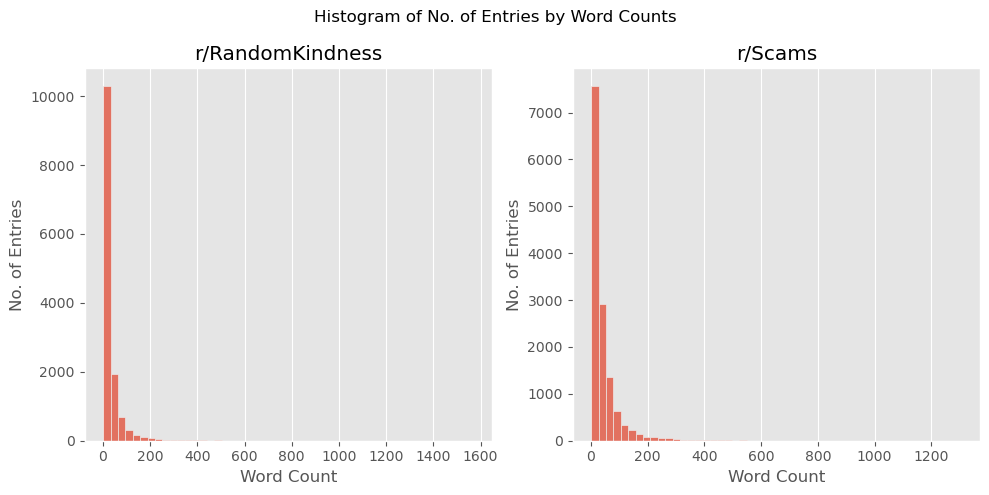

In [19]:
# Histogram of Word Counts of both subreddits
fig, axes = plt.subplots(1,2,figsize=(10, 5))

# histogram for r/RandomKindness
sns.histplot(rk['word_count'], bins=50, kde=False, ax = axes[0])
axes[0].set_title('r/RandomKindness')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('No. of Entries')
axes[0].grid(axis='y')


# histogram for r/Scams
sns.histplot(sc['word_count'], bins=50, kde=False, ax = axes[1])
axes[1].set_title('r/Scams')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('No. of Entries')
axes[1].grid(axis='y')

# include title
plt.suptitle('Histogram of No. of Entries by Word Counts') 
plt.tight_layout()
plt.show()

**Analysis:**
1. Right Skewed Distributions
    - Both subreddits have a relatively low word count on most posts, with decreased frequency as the word count increases.

2. Word Count Range 
    - In r/RandomKindness, number of entries range up to around 11000, with the majority of entries having less than 200 words. 
    - Conversely, r/Scams number of entries range up to around 7500. 
    - Similar to r/RandomKindness, majority of entries have less than 200 words.

3. Comparisons Between Subreddits
    - The histogram for r/RandomKindness has a taller first bin as compared to r/Scams, signifying higher incidences where a posts have shorter text. 
    - Whereas, r/Scams show a more gradual decline in word count, indicating that while most posts are short, a higher proportion of posts have higher word count as compared to r/RandomKindness.

4. Outliers
    - In both subreddits, there is a long tail showing the presence of outliers where there are entries with unusually high word count.

5. Others
    - The lack of bars on the tail end shows that the data is sparse with much fewer entires with high word count. 

##### Histogram of Character Count

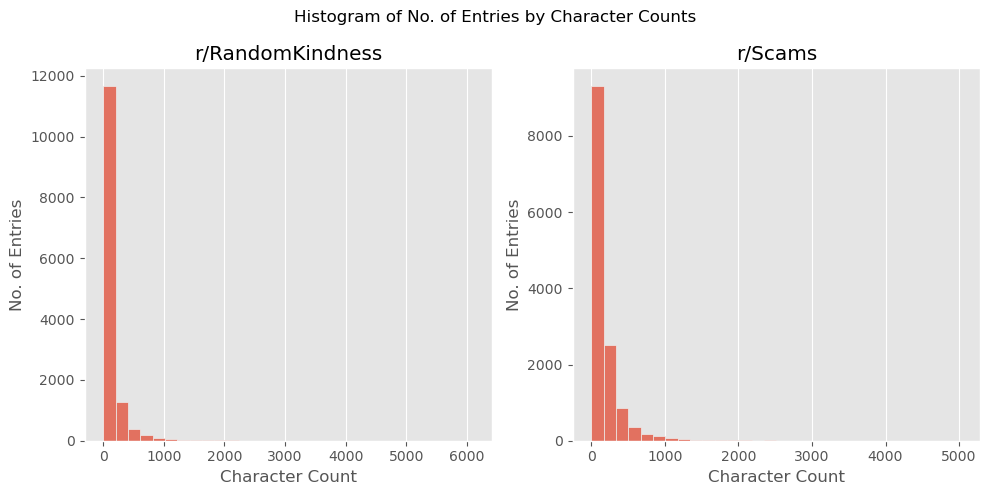

In [20]:
# Histogram of Character Counts of both subreddits
fig, axes = plt.subplots(1,2,figsize=(10, 5))

# histogram for r/RandomKindness
sns.histplot(rk['char_count'], bins=30, kde=False, ax = axes[0])
axes[0].set_title('r/RandomKindness')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('No. of Entries')
axes[0].grid(axis='y')

# histogram for r/Scams
sns.histplot(sc['char_count'], bins=30, kde=False, ax = axes[1])
axes[1].set_title('r/Scams')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('No. of Entries')
axes[1].grid(axis='y')

# include a title
plt.suptitle('Histogram of No. of Entries by Character Counts')

plt.tight_layout()
plt.show()

**Analysis:**

Similar to the Histogram of Word Counts, the trend and distribution are nearly identical. 

1. Right Skewed Distributions
    - Both subreddits have a relatively low character count on most entries, with decreased frequency as the character count increases.

2. Character Count Range 
    - In r/RandomKindness, number of entries range up to approximately 12000, with the majority of entries having less than 1000 characters. 
    - Conversely, r/Scams have character counts that ranged approximately up to 9000 entries. 
    - Similar to r/RandomKindness, majority of entries have less than 1000 characters.

3. Comparisons Between Subreddits
    - The histogram for r/RandomKindness has higher number of entries in the first bin as compared to r/Scams, signifying higher incidences where entries have shorter text. 
    - Whereas, r/Scams show a more gradual decline in character count, indicating that while most entries are short, a higher proportion of entries have lower character count.

4. Outliers
    - In both subreddits, there is a long tail showing the presence of outliers where there are entries with unusually high character count.

5. Others
    - The lack of bars on the tail end shows that the data is sparse with much fewer entries with high characters count. 

#### 3.2.6 Correlation between Word and Character Count

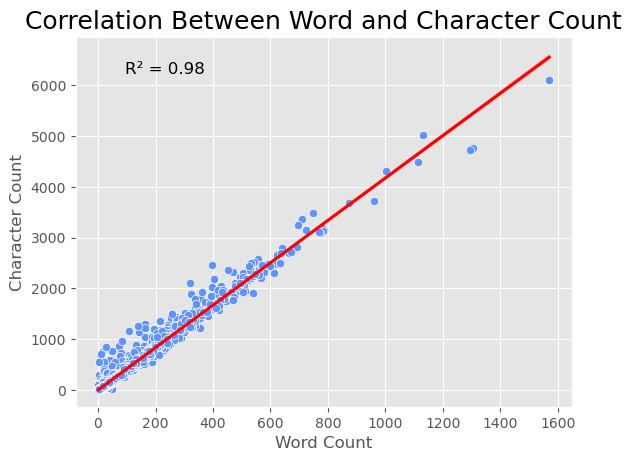

In [21]:
# plot a scatter plot for word count vs character count

# scatterplot
sns.scatterplot(x=clean_df['word_count'], y = clean_df['char_count'], color = '#6093ff')

# include a regression line
regplot = sns.regplot(data=clean_df, x = 'word_count', y = 'char_count', scatter= False, color= 'red')

# Calculate R-squared value
slope, intercept, r_value, p_value, std_err = stats.linregress(clean_df['word_count'], clean_df['char_count'])
r_squared = r_value ** 2

# Add R-squared value to the plot
regplot.annotate(f'R² = {r_squared:.2f}', xy=(0.1, 0.9), xycoords='axes fraction', fontsize=12)

# include plot labels
plt.xlabel('Word Count')
plt.ylabel('Character Count')
plt.title('Correlation Between Word and Character Count', size=18)

plt.show()

**Analysis**

The word and character count is highly correlated with a R2 value of 0.98. Hence, we will be using word counts in the analysis from here on as the values are easily interpretable.

### 3.3 Outliers

#### 3.3.1 Defining the Outlier (using Interquartile Range)

In [22]:
# Define function to get iqr
def get_iqr(some_dataframe):
    # Calculate Q1 and Q3
    Q1 = some_dataframe['word_count'].quantile(0.25)
    Q3 = some_dataframe['word_count'].quantile(0.75)

    # Calculate the IQR
    IQR = Q3 - Q1
    median_value = np.median(some_dataframe['word_count'])

    # Define the multiplier
    multiplier = 1.5

    # Define outliers
    outliers = some_dataframe[(some_dataframe['word_count'] < (Q1 - multiplier * IQR)) | (some_dataframe['word_count'] > (Q3 + multiplier * IQR))]

    return outliers, Q1, Q3, median_value

# get stats from combined df
combined_outlier, combined_Q1, combined_Q3, combined_median = get_iqr(clean_df)

# print percentiles
print('25th percentile: {}, 50th percentile: {}, 75th percentile: {}\n'.format(combined_Q1, combined_Q3, combined_median))


print(combined_outlier.head()) # inspect outliers


25th percentile: 8.0, 50th percentile: 41.0, 75th percentile: 19.0

         id     type       subreddit                                       cleaned_text  word_count  char_count
9   1bkqx22  comment  RandomKindness  you do not sound like a loser at all you sound...         143         571
12  1bkqx22  comment  RandomKindness  well first happy birthday i wish reddit still ...         164         659
20  1bkqx22  comment  RandomKindness  its about you and others gettingbeing excited ...         101         408
33  1bi7w8l     body  RandomKindness  i have this digital camera im not sure what ye...         108         448
38  1bc2j96     body  RandomKindness  its my birthday soon like every year my family...         164         712


#### 3.3.2 Determining the Outliers

In [23]:
# Retrieve the percentile statistics from the subreddits

sc_ol_df,sc_q1,sc_q3,sc_median = get_iqr(sc) # r/Scams
rk_ol_df,rk_q1,rk_q3,rk_median = get_iqr(rk) # r/RandomKindness

print(f'''

r/Scams
-----
The number of words in the 25th percentile: {math.ceil(sc_q1)} words.
The number of words in the 75th percentile: {math.ceil(sc_q3)} words.
The number of words in the 50th percentile (median): {math.ceil(sc_median)} words.
----------------------------------------------------------------------------------

r/RandomKindness
-----
The number of words in the 25th percentile: {math.ceil(rk_q1)} words.
The number of words in the 75th percentile: {math.ceil(rk_q3)} words.
The number of words in the 50th percentile (median): {math.ceil(rk_median)} words.
----------------------------------------------------------------------------------


''')



r/Scams
-----
The number of words in the 25th percentile: 10 words.
The number of words in the 75th percentile: 50 words.
The number of words in the 50th percentile (median): 23 words.
----------------------------------------------------------------------------------

r/RandomKindness
-----
The number of words in the 25th percentile: 7 words.
The number of words in the 75th percentile: 33 words.
The number of words in the 50th percentile (median): 16 words.
----------------------------------------------------------------------------------





#### 3.3.3 Plotting the Outliers

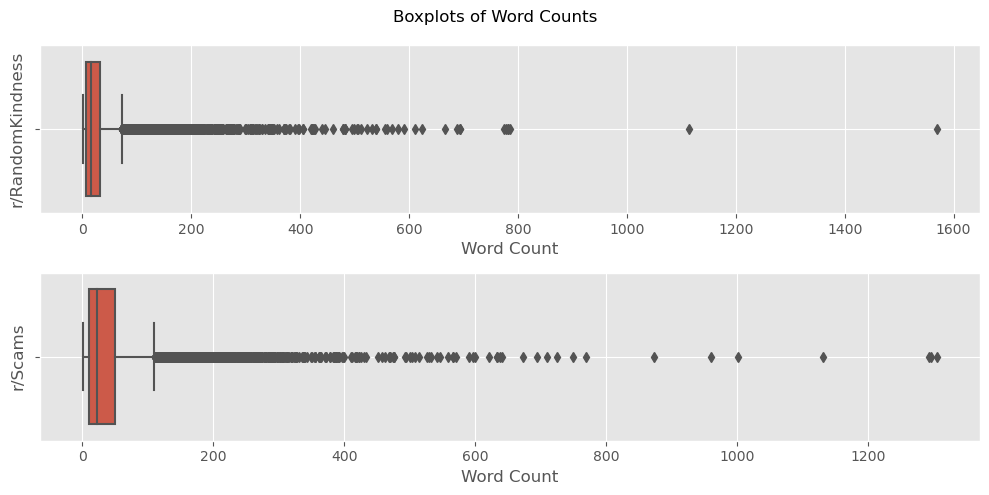

In [24]:
# Boxplots of Word Counts of both subreddits
fig, axes = plt.subplots(2,1,figsize=(10, 5))

sns.boxplot(x='word_count', data=rk, ax = axes[0])
axes[0].set_title('')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('r/RandomKindness')
axes[0].grid(axis='y')

sns.boxplot(x='word_count', data=sc, ax = axes[1])
axes[1].set_title('')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('r/Scams')
axes[1].grid(axis='y')

# include title
plt.suptitle('Boxplots of Word Counts')

plt.tight_layout()
plt.show()

In [25]:
# Filter out outliers from r/Scams and r/RandomKindness

rk_outliers, rk_outlier_Q1, rk_outlier_Q1, rk_outlier_median = get_iqr(rk)
sc_outliers, sc_outlier_Q1, sc_outlier_Q1, sc_outlier_median = get_iqr(sc)

# print(rk_outliers) # inspect the outlier dataframe

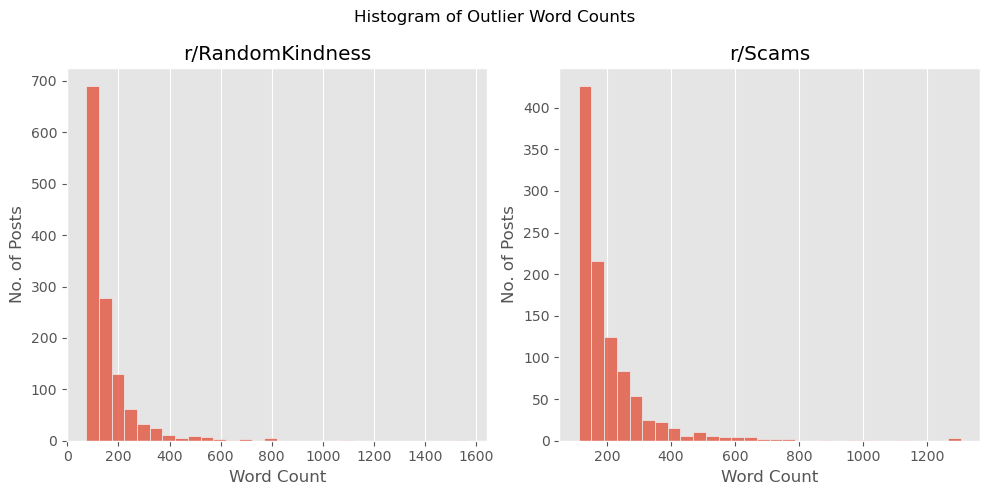

In [26]:
# Histogram of Word Count Outliers
fig, axes = plt.subplots(1,2,figsize=(10, 5))

# outlier histogram for r/RandomKindness
sns.histplot(rk_outliers['word_count'], bins=30, kde=False, ax = axes[0])
axes[0].set_title('r/RandomKindness')
axes[0].set_xlabel('Word Count')
axes[0].set_ylabel('No. of Posts')
axes[0].grid(axis='y')

# outlier histogram for r/Scams
sns.histplot(sc_outliers['word_count'], bins=30, kde=False, ax = axes[1])
axes[1].set_title('r/Scams')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('No. of Posts')
axes[1].grid(axis='y')

# include title
plt.suptitle('Histogram of Outlier Word Counts')

plt.tight_layout()
plt.show()

In [27]:
# Histogram of log(Word Count) Outliers

sc_outliers = sc_outliers.copy() # create a copy
sc_outliers['log_wc'] = [np.log(s) for s in sc_outliers['word_count']]

rk_outliers = rk_outliers.copy() # create a copy
rk_outliers['log_wc'] = [np.log(s) for s in rk_outliers['word_count']]


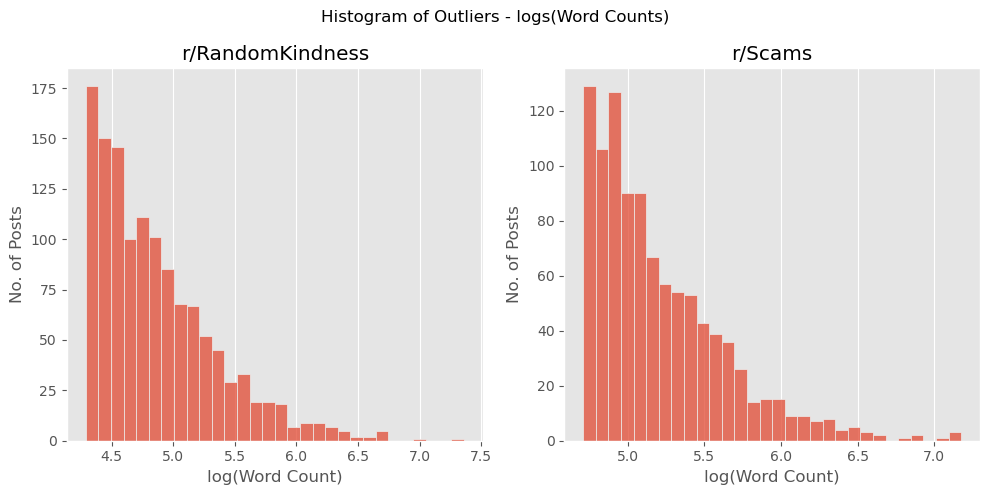

In [28]:

fig, axes = plt.subplots(1,2,figsize=(10, 5))

sns.histplot(rk_outliers['log_wc'], bins=30, kde=False, ax = axes[0])
axes[0].set_title('r/RandomKindness')
axes[0].set_xlabel('log(Word Count)')
axes[0].set_ylabel('No. of Posts')
axes[0].grid(axis='y')

sns.histplot(sc_outliers['log_wc'], bins=30, kde=False, ax = axes[1])
axes[1].set_title('r/Scams')
axes[1].set_xlabel('log(Word Count)')
axes[1].set_ylabel('No. of Posts')
axes[1].grid(axis='y')


plt.suptitle('Histogram of Outliers - logs(Word Counts)')

plt.tight_layout()
plt.show()

#### 3.3.4 Closer Inspection of Outliers

<table>
<tr>
<th>r/RandomKindness Outliers</th>
<th>r/Scams Outliers</th>
</tr>
<tr>
<td><img src='../images/rRandomKindness_outlier_1.jpg' style='width:100%'/></td>
<td><img src='../images/rScams_outlier.jpg' style='width:100%'/></td>
</tr>
<tr>

</tr>
<tr>
<td><img src='../images/rRandomKindness_body_1114_1_outlier.jpg' style='width:100%'/></td>
<td><img src='../images/rScams_comments_1306_1.jpg' style='width:100%'/></td>
</tr>
</table>


**Analysis**
1. Interquartile Range (IQR)
    - The 50% word counts for r/RandomKindness ranges between 7 and 33 words with a median word count of 26. 
    - While the 50% of the word counts for r/Scams are between 10 and 50 with a median of 40 words.

2. Outliers
    - There are plenty of outliers in both subreddits
        - The highest word count observed in r/RandomKindness with 1570 words found in the comments section 
        - The highest word count for r/Scams had 1306 words
    - Further inspections of the outliers show that the contents of either the body of the post or the comments were beneficial to the community instead of junk. Hence, the outliers will be kept in this analysis.